In [1]:
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import h5py
import numpy as np 
from ripser import Rips, ripser
from sklearn import preprocessing
from scipy.spatial.distance import cdist, pdist, squareform
from scipy.ndimage import gaussian_filter1d, gaussian_filter
from scipy.stats import binned_statistic_2d, pearsonr
from scipy.sparse import coo_matrix
from scipy.linalg import eigh
from scipy.sparse.linalg import lsmr
from scipy import stats
from datetime import datetime 
import time
import functools
from scipy import signal
from scipy import optimize
import sys
import numba

import matplotlib.pyplot as plt
import h5py
import numpy as np 
from ripser import Rips, ripser
from sklearn import preprocessing
from scipy.spatial.distance import cdist, pdist, squareform
from scipy.ndimage import gaussian_filter1d, gaussian_filter
from scipy.stats import binned_statistic
from scipy.sparse import coo_matrix
from scipy.linalg import eigh
from scipy.sparse.linalg import lsmr
from scipy import stats
import scipy.io as sio
from scipy.interpolate import CubicSpline
from sklearn.cluster import AgglomerativeClustering
import umap
from datetime import datetime 
import time
import functools
from scipy import signal
from scipy import optimize
import sys
import numba
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import gridspec, transforms
from scipy.special import factorial
import pickle
import glob
import re
import os
from matplotlib.collections import PathCollection
import cv2 as cv

gen_fn_dir = os.path.abspath('..') + '/shared_scripts'
sys.path.append(gen_fn_dir)

def get_coords(cocycle, threshold, num_sampled, dists, coeff):
    zint = np.where(coeff - cocycle[:, 2] < cocycle[:, 2])
    cocycle[zint, 2] = cocycle[zint, 2] - coeff
    d = np.zeros((num_sampled, num_sampled))
    d[np.tril_indices(num_sampled)] = np.NaN
    d[cocycle[:, 1], cocycle[:, 0]] = cocycle[:, 2]
    d[dists > threshold] = np.NaN
#    d[dists == 0] = np.NaN
    edges = np.where(~np.isnan(d))
    verts = np.array(np.unique(edges))
    num_edges = np.shape(edges)[1]
    num_verts = np.size(verts)

    values = d[edges]
    A = np.zeros((num_edges, num_verts), dtype=int)
    v1 = np.zeros((num_edges, 2), dtype=int)
    v2 = np.zeros((num_edges, 2), dtype=int)
    for i in range(num_edges):
        v1[i, :] = [i, np.where(verts == edges[0][i])[0]]
        v2[i, :] = [i, np.where(verts == edges[1][i])[0]]

    A[v1[:, 0], v1[:, 1]] = -1
    A[v2[:, 0], v2[:, 1]] = 1

    L = np.ones((num_edges,))
    Aw = A * np.sqrt(L[:, np.newaxis])
    Bw = values * np.sqrt(L)

    f = lsmr(Aw, Bw)[0]%1
    return f, verts

def get_coords_ds(rips_real, len_indstemp, ph_classes = [0,1], dec_thresh = 0.99, coeff = 47):
    num_circ = len(ph_classes)    
    ################### Decode coordinates ####################
    diagrams = rips_real["dgms"] # the multiset describing the lives of the persistence classes
    cocycles = rips_real["cocycles"][1] # the cocycle representatives for the 1-dim classes
    dists_land = rips_real["dperm2all"] # the pairwise distance between the points 
    births1 = diagrams[1][:, 0] #the time of birth for the 1-dim classes
    deaths1 = diagrams[1][:, 1] #the time of death for the 1-dim classes
    deaths1[np.isinf(deaths1)] = 0
    lives1 = deaths1-births1 # the lifetime for the 1-dim classes
    iMax = np.argsort(lives1)
    coords1 = np.zeros((num_circ, len_indstemp))
    for j,c in enumerate(ph_classes):
        cocycle = cocycles[iMax[-(c+1)]]
        threshold = births1[iMax[-(c+1)]] + (deaths1[iMax[-(c+1)]] - births1[iMax[-(c+1)]])*dec_thresh
        coordstemp,inds = get_coords(cocycle, threshold, len_indstemp, dists_land, coeff)
        coords1[j,inds] = coordstemp
    return coords1

def get_coords_all(sspikes2, coords1, times_cube, indstemp, dim = 7, spk2 = [], bPred = False, bPCA = False):
    num_circ = len(coords1)
    spkmean = np.mean(sspikes2[times_cube,:], axis = 0)
    spkstd = np.std(sspikes2[times_cube,:], axis = 0)
    spkscale = (sspikes2-spkmean)/spkstd
    dspk1 = spkscale.copy()
    if bPCA:
        __, e1, e2,__ = pca(spkscale[times_cube,:], dim = dim)
        dspk1 = np.dot(e1.T, spkscale.T).T    
        dspk1 /= np.sqrt(e2)    
        
    dspk = dspk1[indstemp,:]
    if len(spk2)>0:
        dspk1 = (spk2-spkmean)/spkstd
        if bPCA:
            dspk1 = np.dot(e1.T, dspk1.T).T    
            dspk1 /= np.sqrt(e2)    


    if bPred:
        coords_mod1 = np.zeros((len(dspk1), num_circ))
        coords_mod1[:,0] = predict_color(coords1[0,:], dspk1, dspk, 
                                     dist_measure='cosine',  k = 30)
        coords_mod1[:,1] = predict_color(coords1[1,:],  dspk1, dspk,
                                         dist_measure='cosine',  k = 30)
    else:
        num_neurons = len(dspk[0,:])
        centcosall = np.zeros((num_neurons, num_circ, len(indstemp)))
        centsinall = np.zeros((num_neurons, num_circ, len(indstemp)))    
        for neurid in range(num_neurons):
            spktemp = dspk[:, neurid].copy()
            centcosall[neurid,:,:] = np.multiply(np.cos(coords1[:, :]*2*np.pi),spktemp)
            centsinall[neurid,:,:] = np.multiply(np.sin(coords1[:, :]*2*np.pi),spktemp)

        a = np.zeros((len(dspk1), num_circ, num_neurons))
        for n in range(num_neurons):
            a[:,:,n] = np.multiply(dspk1[:,n:n+1],np.sum(centcosall[n,:,:],1))

        c = np.zeros((len(dspk1), num_circ, num_neurons))
        for n in range(num_neurons):
            c[:,:,n] = np.multiply(dspk1[:,n:n+1],np.sum(centsinall[n,:,:],1))

        mtot2 = np.sum(c,2)
        mtot1 = np.sum(a,2)
        coords_mod1 = np.arctan2(mtot2,mtot1)%(2*np.pi)
    return coords_mod1



def get_cross(sspikes, mouse_sess, lencorr = 10, data_dir = 'place_data'):
    crosscorrfile = glob.glob(data_dir + '/' + mouse_sess + '_crosscorrs.npz')
    if len(crosscorrfile)>0:
        f = np.load(crosscorrfile[0], allow_pickle = True)
        crosscorrs = f['crosscorrs'][()]
        f.close()
    else:
        lenspk, num_neurons = np.shape(sspikes)
        crosscorrs = np.zeros((len(sspikes[0,:]), len(sspikes[0,:]), lencorr*2+1))
        spksum = np.sum(sspikes,0)
        spksum_all = np.zeros((num_neurons, num_neurons))
        for i in range(num_neurons):
            for j in range(num_neurons):
                spksum_all[i,j] = spksum[j]*spksum[i]
        times_all = {}
        
        for it, t1 in enumerate(np.arange(-lencorr, lencorr+1)):
            times_all[it] = np.arange(0,lenspk)+t1+lencorr
            
        for i in range(num_neurons):
            spktemp = np.concatenate((np.zeros(lencorr), sspikes[:,i], np.zeros(lencorr)))
            for j in range(i+1, num_neurons):
                for t1 in times_all:
                    crosscorrs[i,j,t1] = np.dot(sspikes[:,j],spktemp[times_all[it]])/spksum_all[i,j]       
        np.savez(data_dir + '/' + mouse_sess + '_crosscorrs', crosscorrs = crosscorrs)
    return crosscorrs



def get_dgms(sspikes2, maxdim = 1, omega = 1, k  = 1000, 
    n_points = 800, dim = 7, nbs = 800, eps = 1, metric = 'cosine', 
             indstemp = [],movetimes1 = []):    
    dgms_all = {}
    dim_red_spikes_move_scaled = preprocessing.scale(sspikes2, axis = 0)
        
    if dim > 0:
        dim_red_spikes_move_scaled, e1, e2, var_exp = pca(dim_red_spikes_move_scaled, dim = dim)
        dim_red_spikes_move_scaled /= np.sqrt(e2[:dim])  
    else:
        var_exp = 0
    if len(indstemp)==0:
        if len(movetimes1) == 0:
            startindex = np.argmax(np.sum(np.abs(dim_red_spikes_move_scaled),1))
            if eps > 0:
                movetimes1 = radial_downsampling(dim_red_spikes_move_scaled, metric = 'euclidean', epsilon = eps, 
                    startindex = startindex)
            else:
                movetimes1 = np.arange(len(dim_red_spikes_move_scaled))
        indstemp,__  = sample_denoising(dim_red_spikes_move_scaled[movetimes1,:],  k, 
                                           n_points, omega, metric)
        indstemp = movetimes1[indstemp]
    dim_red_spikes_move_scaled = dim_red_spikes_move_scaled[indstemp,:]
    X = squareform(pdist(dim_red_spikes_move_scaled[:,:], metric))
    knn_indices = np.argsort(X)[:, :nbs]
    knn_dists = X[np.arange(X.shape[0])[:, None], knn_indices].copy()
    sigmas, rhos = smooth_knn_dist(knn_dists, nbs, local_connectivity=0)
    rows, cols, vals = compute_membership_strengths(knn_indices, knn_dists, sigmas, rhos)
    result = coo_matrix((vals, (rows, cols)), shape=(X.shape[0], X.shape[0]))
    result.eliminate_zeros()
    transpose = result.transpose()
    prod_matrix = result.multiply(transpose)
    result = (result + transpose - prod_matrix)
    result.eliminate_zeros()
    d = result.toarray()
    d = -np.log(d)
    np.fill_diagonal(d,0)
    thresh = np.max(d[~np.isinf(d)])
    if maxdim == 2:
        hom_dims = list(range(maxdim+1))
        VR = VietorisRipsPersistence(
        homology_dimensions=hom_dims,
        metric='precomputed',
        coeff=47,
        max_edge_length= thresh,
        collapse_edges=False,  # True faster?
        n_jobs=None  # -1 faster?
        )
        diagrams = VR.fit_transform([d])
        dgms_all[0] = from_giotto_to_ripser(diagrams[0])
        persistence = []
    else:
        persistence = ripser(d, maxdim=1, coeff=47, do_cocycles= True, distance_matrix = True, thresh = thresh)    
        dgms_all[0] = persistence['dgms'] 
    return dgms_all, persistence, indstemp, movetimes1, var_exp

def plot_barcode(persistence, file_name = '', shuffle_name = ''):
    if np.sum(np.isinf(persistence[0])) == 0:
        persistence[0] = np.concatenate((persistence[0], np.array([0,np.inf])[np.newaxis, :]),0)

    diagrams_roll = {}
    if len(shuffle_name)>0:
        f = np.load(shuffle_name + '.npz', allow_pickle = True)
        diagrams_roll = f['dgms_shuffles'][()]
        f.close() 

    alpha=1
    inf_delta=0.1
    legend=True
    maxdim = len(persistence)-1
    cs = np.repeat([[0,0.55,0.2]],maxdim+1).reshape(3, maxdim+1).T
    colormap=cs
    dims =np.arange(maxdim+1)
    num_rolls = len(diagrams_roll)
    print(num_rolls)
    if num_rolls>0:
        diagrams_all = np.copy(diagrams_roll[0][0])
        for i in np.arange(1, num_rolls):
            for d in dims:
                diagrams_all[d] = np.concatenate((diagrams_all[d], diagrams_roll[i][0][d]),0)
        infs = np.isinf(diagrams_all[0])
        diagrams_all[0][infs] = 0
        diagrams_all[0][infs] = np.max(diagrams_all[0])
        infs = np.isinf(diagrams_all[0])
        diagrams_all[0][infs] = 0
        diagrams_all[0][infs] = np.max(diagrams_all[0])


    min_birth, max_death = 0,0            
    for dim in dims:
        persistence_dim = persistence[dim][~np.isinf(persistence[dim][:,1]),:]
        if len(persistence_dim)>0:
            min_birth = min(min_birth, np.min(persistence_dim))
            max_death = max(max_death, np.max(persistence_dim))
    delta = (max_death - min_birth) * inf_delta
    infinity = max_death + delta
    axis_start = min_birth - delta            
    plotind = (dims[-1]+1)*100 + 10 +1
    fig = plt.figure(figsize = (3,5), dpi = 160)
    gs = gridspec.GridSpec(len(dims),1, height_ratios = [min(len(persistence[dim]),30) for dim in dims])
    indsall =  0
    labels = ["$H_0$", "$H_1$", "$H_2$"]
    for dit, dim in enumerate(dims):
        axes = plt.subplot(gs[dim])
        axes.axis('off')
        d = np.copy(persistence[dim])
        d[np.isinf(d[:,1]),1] = infinity
        dlife = (d[:,1] - d[:,0])
        if len(dlife)>1:
            dinds = np.argsort(dlife)[-30:]
            dl1,dl2 = dlife[dinds[-2:]]
        else:
            dinds = np.array([0])
        if dim>0:
            dinds = dinds[np.flip(np.argsort(d[dinds,0]))]
        axes.barh(
            0.5+np.arange(len(dinds)),
            dlife[dinds],
            height=0.8,
            left=d[dinds,0],
            alpha=alpha,
            color=colormap[dim],
            linewidth=0,
        )
        indsall = len(dinds)
        if num_rolls>0:
            bins = 50
            cs = np.flip([[0.4,0.4,0.4], [0.6,0.6,0.6], [0.8, 0.8,0.8]])
            cs = np.repeat([[1,0.55,0.1]],3).reshape(3,3).T
            cc = 0
            lives1_all = diagrams_all[dim][:,1] - diagrams_all[dim][:,0]
            x1 = np.linspace(diagrams_all[dim][:,0].min()-1e-5, diagrams_all[dim][:,0].max()+1e-5, bins-2)
            
            dx1 = (x1[1] - x1[0])
            x1 = np.concatenate(([x1[0]-dx1], x1, [x1[-1]+dx1]))
            dx = x1[:-1] + dx1/2
            ytemp = np.zeros((bins-1))
            binned_birth = np.digitize(diagrams_all[dim][:,0], x1)-1
            x1  = d[dinds,0]
            ytemp =x1 + np.max(lives1_all)
            axes.fill_betweenx(0.5+np.arange(len(dinds)), x1, ytemp, color = cs[(dim)], zorder = -2, alpha = 0.3)

        axes.plot([0,0], [-0.5, indsall], c = 'k', linestyle = '-', lw = 3)
        axes.plot([0,infinity],[-0.5,-0.5], c = 'k', linestyle = '-', lw = 3)
        axes.set_xlim([0, infinity])
        print('infinity', infinity)
    
    plt.tight_layout()
    return fig


def pca(data, dim=2):
    if dim < 1:
        return data, [0]
    m, n = data.shape
    # mean center the data
    # data -= data.mean(axis=0)
    # calculate the covariance matrix
    R = np.cov(data, rowvar=False)
    # calculate eigenvectors & eigenvalues of the covariance matrix
    # use 'eigh' rather than 'eig' since R is symmetric,
    # the performance gain is substantial
    evals, evecs = np.linalg.eig(R)
    # sort eigenvalue in decreasing order
    idx = np.argsort(evals)[::-1]
    evecs = evecs[:,idx]
    # sort eigenvectors according to same index
    evals = evals[idx]
    # select the first n eigenvectors (n is desired dimension
    # of rescaled data array, or dims_rescaled_data)
    evecs = evecs[:, :dim]
    # carry out the transformation on the data using eigenvectors
    # and return the re-scaled data, eigenvalues, and eigenvectors

    tot = np.sum(evals)
    var_exp = [(i / tot) * 100 for i in sorted(evals[:], reverse=True)]
    cum_var_exp = np.cumsum(var_exp)
    components = np.dot(evecs.T, data.T).T
    return components, evecs, evals[:dim], var_exp
@numba.njit(parallel=True, fastmath=True)
def compute_membership_strengths(knn_indices, knn_dists, sigmas, rhos):
    n_samples = knn_indices.shape[0]
    n_neighbors = knn_indices.shape[1]
    rows = np.zeros((n_samples * n_neighbors), dtype=np.int64)
    cols = np.zeros((n_samples * n_neighbors), dtype=np.int64)
    vals = np.zeros((n_samples * n_neighbors), dtype=np.float64)
    for i in range(n_samples):
        for j in range(n_neighbors):
            if knn_indices[i, j] == -1:
                continue  # We didn't get the full knn for i
            if knn_indices[i, j] == i:
                val = 0.0
            elif knn_dists[i, j] - rhos[i] <= 0.0:
                val = 1.0
            else:
                val = np.exp(-((knn_dists[i, j] - rhos[i]) / (sigmas[i])))
                #val = ((knn_dists[i, j] - rhos[i]) / (sigmas[i]))

            rows[i * n_neighbors + j] = i
            cols[i * n_neighbors + j] = knn_indices[i, j]
            vals[i * n_neighbors + j] = val

    return rows, cols, vals
@numba.njit(
    fastmath=True
)  # benchmarking `parallel=True` shows it to *decrease* performance
def smooth_knn_dist(distances, k, n_iter=64, local_connectivity=0.0, bandwidth=1.0):
    target = np.log2(k) * bandwidth
#    target = np.log(k) * bandwidth
#    target = k
    
    rho = np.zeros(distances.shape[0])
    result = np.zeros(distances.shape[0])

    mean_distances = np.mean(distances)

    for i in range(distances.shape[0]):
        lo = 0.0
        hi = np.inf
        mid = 1.0

        # TODO: This is very inefficient, but will do for now. FIXME
        ith_distances = distances[i]
        non_zero_dists = ith_distances[ith_distances > 0.0]
        if non_zero_dists.shape[0] >= local_connectivity:
            index = int(np.floor(local_connectivity))
            interpolation = local_connectivity - index
            if index > 0:
                rho[i] = non_zero_dists[index - 1]
                if interpolation > 1e-5:
                    rho[i] += interpolation * (
                        non_zero_dists[index] - non_zero_dists[index - 1]
                    )
            else:
                rho[i] = interpolation * non_zero_dists[0]
        elif non_zero_dists.shape[0] > 0:
            rho[i] = np.max(non_zero_dists)

        for n in range(n_iter):

            psum = 0.0
            for j in range(1, distances.shape[1]):
                d = distances[i, j] - rho[i]
                if d > 0:
                    psum += np.exp(-(d / mid))
#                    psum += d / mid
 
                else:
                    psum += 1.0
#                    psum += 0

            if np.fabs(psum - target) < 1e-5:
                break

            if psum > target:
                hi = mid
                mid = (lo + hi) / 2.0
            else:
                lo = mid
                if hi == np.inf:
                    mid *= 2
                else:
                    mid = (lo + hi) / 2.0
        result[i] = mid
        # TODO: This is very inefficient, but will do for now. FIXME
        if rho[i] > 0.0:
            mean_ith_distances = np.mean(ith_distances)
            if result[i] < 1e-3 * mean_ith_distances:
                result[i] = 1e-3 * mean_ith_distances
        else:
            if result[i] < 1e-3 * mean_distances:
                result[i] = 1e-3 * mean_distances

    return result, rho
def sample_denoising(data,  k = 10, num_sample = 500, omega = 1, metric = 'euclidean'):    
    n = data.shape[0]
    leftinds = np.arange(n)
    F_D = np.zeros(n)

    X = squareform(pdist(data, metric))
    knn_indices = np.argsort(X)[:, :k]
    knn_dists = X[np.arange(X.shape[0])[:, None], knn_indices].copy()

    sigmas, rhos = smooth_knn_dist(knn_dists, k, local_connectivity=0)
    rows, cols, vals = compute_membership_strengths(knn_indices, knn_dists, sigmas, rhos)
    result = coo_matrix((vals, (rows, cols)), shape=(n, n))
    result.eliminate_zeros()
    transpose = result.transpose()
    prod_matrix = result.multiply(transpose)

    result = (result + transpose - prod_matrix)
    result.eliminate_zeros()
    X = result.toarray()
    F = np.sum(X,1)
    print(np.mean(F),np.median(F))
    Fs = np.zeros(num_sample)
    Fs[0] = np.max(F)
    i = np.argmax(F)
    inds_all = np.arange(n)
    inds_left = inds_all>-1
    inds_left[i] = False
    inds = []
    j = 0
    for j in np.arange(1,num_sample):
        F -= omega*X[i,:]
        Fmax = np.argmax(F[inds_left])
        Fs[j] = F[inds_left][Fmax]
        i = inds_all[inds_left][Fmax]
        
        inds_left[i] = False   
        inds.extend([i])
    return inds, Fs

def load_data(session):
    ff = glob.glob('Data/' + session + '_25.npz')
    if len(ff)>0:
        f = np.load(ff[0], allow_pickle = True)
        ccg = f['ccg'] 
        spikes_bin = f['spikes_bin'][()]
        hdd = f['hdd']
        xx = f['xx']
        yy = f['yy']    
        ind = f['ind']
        f.close()
    else:
        data_path = 'Data/' + session + '/'
        f = np.load(data_path + 'data.npz', allow_pickle = True)
        data = f['data'][()]
        f.close()        
        angle_list_orig = np.array(read_numerical_file('Data/' + session + '/' + session + '.ang', 'float', 'multiple'))
        angle_list = np.array(angle_list_orig[:,1])
        angle_list[angle_list < -0.5] = np.nan
        angle_times  =angle_list_orig[:,0]
        data['angle_list'] = angle_list
        data['angle_times'] = angle_times
        spike_times =data['spike_times']
        hd = data['angle_list']
        samp_rate = data['pos_sampling_rate']

        area_info = load_pickle_file('Data/area_shank_info.p')
        relevant_shanks = area_info[session]['ADn']
        spike_times1 = {}
        spikes_bin = {}
        
        it = 0
        for spk in spike_times:
            numspk = sum((spike_times[spk]>=data['state_times']['Wake'][0][0]) & 
                   (spike_times[spk]<=data['state_times']['Wake'][0][1]))
            lensess = data['state_times']['Wake'][0][1]-data['state_times']['Wake'][0][0]
            fr = numspk/lensess
    #        if spk[0] in relevant_shanks:
            if (fr>=0.05) | (fr<10):
                spike_times1[it] = spike_times[spk]
                it += 1
            else:
                print('fr ', fr)
            
        for brain_state in ['Wake', 'REM', 'SWS']:
            t_curr =  data['state_times'][brain_state]
            res = 100000
            if brain_state == 'SWS':
                dt = 200000
                sigma = 5000
            else:
                dt = 25000
                sigma = 25000
            thresh = 250000
            num_thresh = int(thresh/dt)
            num2_thresh = int(2*num_thresh)
            sig2 = 1/(2*(sigma/res)**2)
            ker = np.exp(-np.power(np.arange(thresh+1)/res, 2)*sig2)
            kerwhere = np.arange(-num_thresh,num_thresh)*dt

            spikes_bin_tmp = np.zeros((1,len(spike_times1)))
            for ttmp in t_curr:
                min_time = ttmp[0]*res
                max_time = ttmp[-1]*res
                tt = np.arange(np.floor(min_time), np.ceil(max_time)+1, dt)

                spikes_temp = np.zeros((len(tt)+num2_thresh, len(spike_times1)))
                for n, spk in enumerate(spike_times1):
                    spk = spike_times1[spk]
                    spikes = np.array(spk*res-min_time, dtype = int)
                    spikes = spikes[(spikes < (max_time-min_time)) & (spikes > 0)]
                    spikes_mod = dt-spikes%dt
                    spikes = np.array(spikes/dt, int)
                    for m, j in enumerate(spikes):
                        spikes_temp[j:j+num2_thresh, n] += ker[np.abs(kerwhere+spikes_mod[m])]
                spikes_temp = spikes_temp[num_thresh-1:-(num_thresh+1),:]
                spikes_bin_tmp = np.concatenate((spikes_bin_tmp, spikes_temp),0)
            spikes_bin[brain_state] = spikes_bin_tmp[1:,:]
            spikes_bin[brain_state] *= 1/np.sqrt(2*np.pi*(sigma/res)**2)
            if brain_state == 'Wake':
                pos_list_orig = np.array(read_numerical_file('Data/'+ session + '/' + session + '.pos', 'float', 'multiple'))
                t = pos_list_orig[:,0]
                x = pos_list_orig[:,1]
                y = pos_list_orig[:,2]
                tt/=res
                nnans = ~np.isnan(x)
                xspline = CubicSpline(t[nnans], x[nnans]) 
                nnans = ~np.isnan(y)
                yspline = CubicSpline(t[nnans], y[nnans]) 
                nnans = ~np.isnan(hd)
                hdsplinecos = CubicSpline(t[nnans], np.cos(hd[nnans]))
                hdsplinesin = CubicSpline(t[nnans], np.sin(hd[nnans]))
                xx = xspline(tt)
                yy = yspline(tt)
                hdd = np.arctan2(hdsplinesin(tt), hdsplinecos(tt))%(2*np.pi)   

        ccg = get_cross(session, data, spike_times1, data_dir = 'Data', spike_times = [], files = ['Wake', 'REM', 'SWS'])
        ind = get_ind(session, ccg, data_dir = 'Data', files = ['Wake', 'REM', 'SWS'], nbs = 0.6)

        np.savez('Data/' + session + '_25', ind = ind, ccg = ccg, spikes_bin = spikes_bin, hdd = hdd, xx = xx, yy = yy)
    return ind, ccg, spikes_bin, hdd, xx, yy

def get_cross(sspikes, mouse_sess, lencorr = 10, data_dir = 'place_data'):
    crosscorrfile = glob.glob(data_dir + '/' + mouse_sess + '_crosscorrs.npz')
    if len(crosscorrfile)>0:
        f = np.load(crosscorrfile[0], allow_pickle = True)
        crosscorrs = f['crosscorrs'][()]
        f.close()
    else:
        lenspk, num_neurons = np.shape(sspikes)
        crosscorrs = np.zeros((len(sspikes[0,:]), len(sspikes[0,:]), lencorr*2+1))
        spksum = np.sum(sspikes,0)
        spksum_all = np.zeros((num_neurons, num_neurons))
        for i in range(num_neurons):
            for j in range(num_neurons):
                spksum_all[i,j] = spksum[j]*spksum[i]
        times_all = {}
        
        for it, t1 in enumerate(np.arange(-lencorr, lencorr+1)):
            times_all[it] = np.arange(0,lenspk)+t1+lencorr
            
        for i in range(num_neurons):
            spktemp = np.concatenate((np.zeros(lencorr), sspikes[:,i], np.zeros(lencorr)))
            for j in range(i+1, num_neurons):
                for it in times_all:
                    crosscorrs[i,j,it] = np.dot(sspikes[:,j],spktemp[times_all[it]])/spksum_all[i,j]       
        np.savez(data_dir + '/' + mouse_sess + '_crosscorrs', crosscorrs = crosscorrs)
    return crosscorrs

def get_crossmat(crosscorr_train, lenspk, lencorr = -1):
    num_neurons = len(crosscorr_train)
    crosscorrs = np.zeros((num_neurons,num_neurons))
    num_neurons = len(crosscorr_train[:,0,0])
    lenorig = int(len(crosscorr_train[0,0,:])/2)
    if lencorr==-1:
        lencorr = lenorig
    for i in range(num_neurons):
        for j in range(i+1, num_neurons):
            c = crosscorr_train[i,j,lenorig-lencorr:lenorig+lencorr+1].copy()*lenspk

#            c = crosscorr_train[i,j,:].copy()*lenspk
            if np.min(c)>0:
                #crosscorrs[i,j] +=  1-np.exp(-np.square(np.min(c)/np.max(c)))
                crosscorrs[i,j] +=  1/np.max(c)#np.mean(np.exp(-np.square(c)))#-np.min(c))#np.exp(-np.sum(c))#-np.min(c)
            crosscorrs[j,i] = crosscorrs[i,j]
    print(np.unique(crosscorrs))
    crosscorrs[np.isnan(crosscorrs)] = 1
    crosscorrs[np.isinf(crosscorrs)] = 1
    return crosscorrs

def get_ind(crosscorrs, nbs = -1, linkage = 'average'):
    ################### Get crosscorr stats ####################
    crosscorrs[np.isinf(crosscorrs)] = 2*np.max(crosscorrs[~np.isinf(crosscorrs)])
    agg = AgglomerativeClustering(n_clusters=None,affinity='precomputed', linkage=linkage, 
                                  distance_threshold=nbs)
    ind = agg.fit(crosscorrs).labels_
    
    fig = plt.figure()
    crosscorrs = crosscorrs[np.argsort(ind), :]
    crosscorrs = crosscorrs[:, np.argsort(ind)]    
    plt.imshow(crosscorrs)
    return ind

def radial_downsampling(data_in, epsilon = 0.1, metric = 'euclidean', startindex = -1):    
    n = data_in.shape[0]
    np.random.seed(0) 
    if epsilon > 0:
        n = data_in.shape[0]
        if startindex == -1:
            startindex = np.random.randint(n)
        i = startindex
        j = 1
        inds = np.zeros((n, ), dtype=int)
        inds1 = np.arange(n, dtype=int)
        dists = np.zeros((n, ))
        while j < n+1:
            disttemp = (cdist(data_in[i, :].reshape(1, -1), data_in[inds1, :], metric=metric) - epsilon)[0]                        
            dists[inds1] = np.max(np.concatenate((dists[inds1][:,np.newaxis], disttemp[:,np.newaxis]),1),1)
            inds[i] = j
            inds1 = inds1[disttemp>0]
            j = j+1
            if len(inds1)>0:
                i = inds1[np.argmin(dists[inds1])]
#                i = inds1[np.argmax(dists[inds1])]
#                i = inds1[np.argmax(disttemp[disttemp>0])]

            else:
                break
    else:
        inds = np.ones(range(np.shape(data_in)[0]))
    inds = np.where(inds)[0]
    return inds



def predict_color(circ_coord_sampled, data, sampled_data, dist_measure='euclidean', num_batch =20000, k = 10):
    num_tot = len(data)
#    zero_spikes = np.where(np.sum(data,1) == 0)[0]
#    if len(zero_spikes):
#       data[zero_spikes,:] += 1e-10 
    circ_coord_tot = np.zeros(num_tot)
    circ_coord_dist = np.zeros(num_tot)
    circ_coord_tmp = circ_coord_sampled*2*np.pi
    j = -1
    for j in range(int(num_tot/num_batch)):
        dist_landmarks = cdist(data[j*num_batch:(j+1)*num_batch, :], sampled_data, metric = dist_measure)
        closest_landmark = np.argsort(dist_landmarks, 1)[:,:k]
        weights = np.array([1-dist_landmarks[i,closest_landmark[i,:]]/dist_landmarks[i,closest_landmark[i,-1]] for i in range(num_batch)])
        nans = np.where(np.sum(weights,1)==0)[0]
        if len(nans)>0:
            weights[nans,:] = 1
        weights /= np.sum(weights, 1)[:,np.newaxis] 

        sincirc = [np.dot(np.sin(circ_coord_tmp[closest_landmark[i,:]]), weights[i,:]) for i in range(num_batch)]
        coscirc = [np.dot(np.cos(circ_coord_tmp[closest_landmark[i,:]]), weights[i,:]) for i in range(num_batch)]
        circ_coord_tot[j*num_batch:(j+1)*num_batch] = np.arctan2(sincirc, coscirc)%(2*np.pi)

    dist_landmarks = cdist(data[(j+1)*num_batch:, :], sampled_data, metric = dist_measure)
    closest_landmark = np.argsort(dist_landmarks, 1)[:,:k]
    lenrest = len(closest_landmark[:,0])
    weights = np.array([1-dist_landmarks[i,closest_landmark[i,:]]/dist_landmarks[i,closest_landmark[i,k-1:k]] for i in range(lenrest)])
    if np.shape(weights)[0] == 0:
        nans = np.where(np.sum(weights,1)==0)[0]
        if len(nans)>0:
            weights[nans,:] = 1 
        weights /= np.sum(weights)
    else:
        nans = np.where(np.sum(weights,1)==0)[0]
        if len(nans)>0:
            weights[nans,:] = 1
        weights /= np.sum(weights, 1)[:,np.newaxis] 
    sincirc = [np.dot(np.sin(circ_coord_tmp[closest_landmark[i,:]]), weights[i,:]) for i in range(lenrest)]
    coscirc = [np.dot(np.cos(circ_coord_tmp[closest_landmark[i,:]]), weights[i,:]) for i in range(lenrest)]
    circ_coord_tot[(j+1)*num_batch:] = np.arctan2(sincirc, coscirc)%(2*np.pi)
    return circ_coord_tot

def information_score(mtemp, circ, mu):
    numangsint = mtemp.shape[0]+1
    circ = np.ravel_multi_index(circ-1, np.shape(mtemp))
    mtemp = mtemp.flatten() 
    p = np.bincount(circ, minlength = (numangsint-1)**2)/len(circ)
    logtemp = np.log2(mtemp/mu)
    mtemp = np.multiply(np.multiply(mtemp,p), logtemp)
    return np.sum(mtemp[~np.isnan(mtemp)])
def circmean(x):
    return np.arctan2(np.mean(np.sin(x)), np.mean(np.cos(x)))


def smooth_tuning_map(mtot, numangsint, sig, bClose = True):
    numangsint_1 = numangsint-1
    mid = int((numangsint_1)/2)
    indstemp1 = np.zeros((numangsint_1,numangsint_1), dtype=int)
    indstemp1[indstemp1==0] = np.arange((numangsint_1)**2)
    indstemp1temp = indstemp1.copy()
    mid = int((numangsint_1)/2)
    mtemp1_3 = mtot.copy()
    for i in range(numangsint_1):
        mtemp1_3[i,:] = np.roll(mtemp1_3[i,:],int(i/2))
    mtot_out = np.zeros_like(mtot)
    mtemp1_4 = np.concatenate((mtemp1_3, mtemp1_3, mtemp1_3),1)
    mtemp1_5 = np.zeros_like(mtemp1_4)
    mtemp1_5[:, :mid] = mtemp1_4[:, (numangsint_1)*3-mid:]  
    mtemp1_5[:, mid:] = mtemp1_4[:,:(numangsint_1)*3-mid]      
    mtemp1_6 = np.concatenate((mtemp1_5,mtemp1_4,mtemp1_5)) 
    if bClose:
        nans = np.isnan(mtemp1_6)
        mtemp1_6[nans] = np.mean(mtemp1_6[~nans])
        mtemp1_6 = gaussian_filter(mtemp1_6,sigma = sig)
        mtemp1_6[nans] = np.nan
        radius = 1
        L = np.arange(-radius, radius + 1)
        X, Y = np.meshgrid(L, L)
        kernel = np.array((X ** 2 + Y ** 2) <= radius ** 2).astype(np.uint8)        
        mtemp1_6 = cv.morphologyEx(mtemp1_6, cv.MORPH_CLOSE, kernel, iterations = 1)
    else:
        mtemp1_6 = gaussian_filter(mtemp1_6, sigma = sig)
    for i in range(numangsint_1):
        mtot_out[i, :] = mtemp1_6[(numangsint_1)+i, 
                                          (numangsint_1) + (int(i/2) +1):(numangsint_1)*2 + (int(i/2) +1)] 
    return mtot_out

def plot_barcode(persistence, file_name = '', shuffle_name = ''):
    if np.sum(np.isinf(persistence[0])) == 0:
        persistence[0] = np.concatenate((persistence[0], np.array([0,np.inf])[np.newaxis, :]),0)

    diagrams_roll = {}
    if len(shuffle_name)>0:
        f = np.load(shuffle_name + '.npz', allow_pickle = True)
        diagrams_roll = f['dgms_shuffles'][()]
        f.close() 

    alpha=1
    inf_delta=0.1
    legend=True
    maxdim = len(persistence)-1
    cs = np.repeat([[0,0.55,0.2]],maxdim+1).reshape(3, maxdim+1).T
    colormap=cs
    dims =np.arange(maxdim+1)
    num_rolls = len(diagrams_roll)
    print(num_rolls)
    if num_rolls>0:
        diagrams_all = [[] for d in dims]
        for i in np.arange(1, num_rolls):
            for d in dims:
                currdgms = diagrams_roll[i][0][d]
                infs = np.isinf(currdgms)
                currdgms[infs] = 0
                currdgms[infs] = np.max(currdgms)
                lives1_all = np.sort(currdgms[:,1] - currdgms[:,0])
                diagrams_all[d].append(np.max(lives1_all))


    min_birth, max_death = 0,0            
    for dim in dims:
        persistence_dim = persistence[dim][~np.isinf(persistence[dim][:,1]),:]
        if len(persistence_dim)>0:
            min_birth = min(min_birth, np.min(persistence_dim))
            max_death = max(max_death, np.max(persistence_dim))
    delta = (max_death - min_birth) * inf_delta
    infinity = max_death + delta
    axis_start = min_birth - delta            
    plotind = (dims[-1]+1)*100 + 10 +1
    fig = plt.figure(figsize = (3,5), dpi = 160)
    gs = gridspec.GridSpec(len(dims),1, height_ratios = [min(len(persistence[dim]),30) for dim in dims])
    indsall =  0
    labels = ["$H_0$", "$H_1$", "$H_2$"]
    for dit, dim in enumerate(dims):
        axes = plt.subplot(gs[dim])
        axes.axis('off')
        d = np.copy(persistence[dim])
        d[np.isinf(d[:,1]),1] = infinity
        dlife = (d[:,1] - d[:,0])
        if len(dlife)>1:
            dinds = np.argsort(dlife)[-30:]
            dl1,dl2 = dlife[dinds[-2:]]
        else:
            dinds = np.array([0])
        if dim>0:
            dinds = dinds[np.flip(np.argsort(d[dinds,0]))]
        axes.barh(
            0.5+np.arange(len(dinds)),
            dlife[dinds],
            height=0.8,
            left=d[dinds,0],
            alpha=alpha,
            color=colormap[dim],
            linewidth=0,
        )
        indsall = len(dinds)
        if num_rolls>0:
            bins = 50
            cs = np.flip([[0.4,0.4,0.4], [0.6,0.6,0.6], [0.8, 0.8,0.8]])
            cs = np.repeat([[1,0.55,0.1]],3).reshape(3,3).T
            cc = 0
            lives1_all = np.sort(diagrams_all[dim])
            x1  = d[dinds,0]
            ytemp1 =x1 + lives1_all[-1]
            ytemp2 =x1 + lives1_all[-5]
            ytemp3 =x1 + lives1_all[-25]
            print(ytemp1)
            axes.plot(ytemp1, 0.5+np.arange(len(dinds)), color = [0.6,0.6,0.6], lw = 2,  zorder = -2, alpha = 0.9, ls = ':')
#            axes.plot(ytemp2, 0.5+np.arange(len(dinds)), color = [0.3,0.3,0.3], lw = 2, alpha = 0.9, ls = ':')
#            axes.plot(ytemp3, 0.5+np.arange(len(dinds)), color = [0.2,0.2,0.2], lw = 2,  alpha = 0.9, ls = ':')
#            axes.plot(ytemp1, 0.5+np.arange(len(dinds)), color = [0.6,0.6,0.6], lw = 2, zorder = -2, alpha = 0.9, ls = ':')
#            axes.plot(ytemp2, 0.5+np.arange(len(dinds)), color = [0.4,0.4,0.4], lw = 2, zorder = -2,alpha = 0.9, ls = ':')
#            axes.plot(ytemp3, 0.5+np.arange(len(dinds)), color = [0.2,0.2,0.2], lw = 2, zorder = -2, alpha = 0.9, ls = ':')
            axes.fill_betweenx(0.5+np.arange(len(dinds)), x1, ytemp2, color = [0.8,0.8,0.8], zorder = -2, alpha = 0.5)

        axes.plot([0,0], [-0.5, indsall], c = 'k', linestyle = '-', lw = 2)
        axes.plot([0,infinity],[-0.5,-0.5], c = 'k', linestyle = '-', lw = 1)
        axes.set_xlim([0, infinity])
        print('infinity', infinity)
    
    plt.tight_layout()
    return fig



20210308
17.622514717364545 17.89837902991079


C:\Users\Finnern\AppData\Local\Temp/ipykernel_21168/391287716.py:220: RuntimeWarning: divide by zero encountered in log
  d = -np.log(d)


0
infinity 9.526734161376954
infinity 9.526734161376954


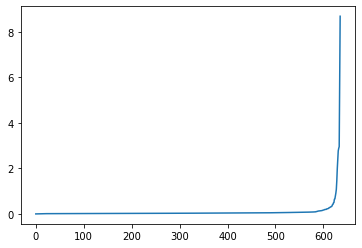

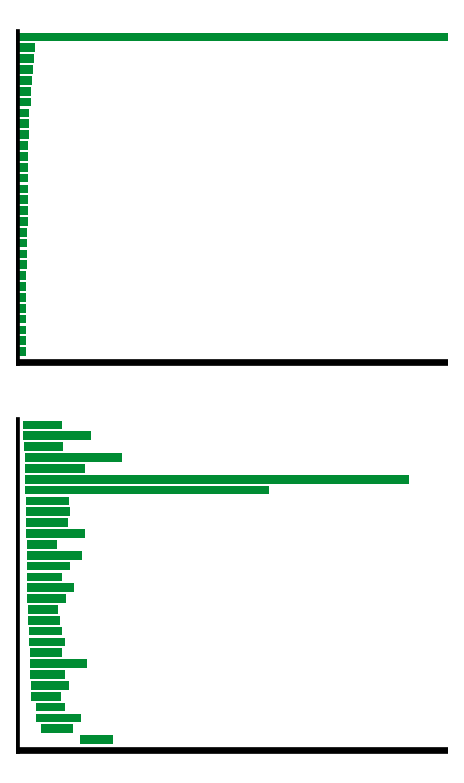

C:\Users\Finnern\AppData\Local\Temp/ipykernel_21168/391287716.py:75: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  v1[i, :] = [i, np.where(verts == edges[0][i])[0]]
C:\Users\Finnern\AppData\Local\Temp/ipykernel_21168/391287716.py:76: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  v2[i, :] = [i, np.where(verts == edges[1][i])[0]]


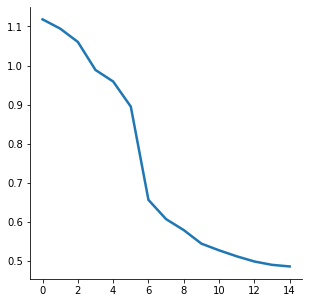

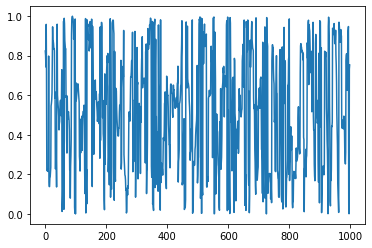

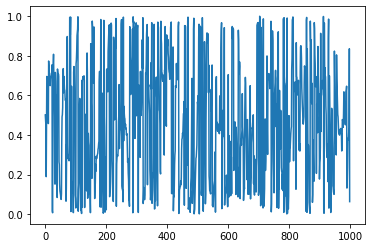

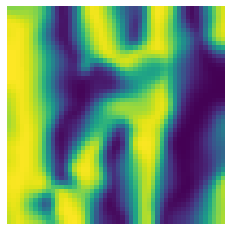

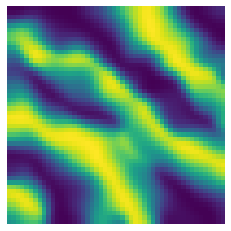

20210312
17.744671970063802 18.17502717294144


C:\Users\Finnern\AppData\Local\Temp/ipykernel_21168/391287716.py:220: RuntimeWarning: divide by zero encountered in log
  d = -np.log(d)


0
infinity 13.584928035736084
infinity 13.584928035736084


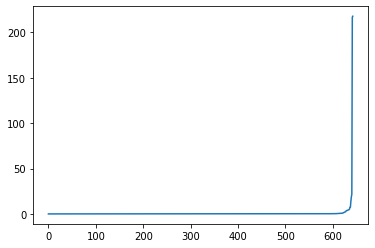

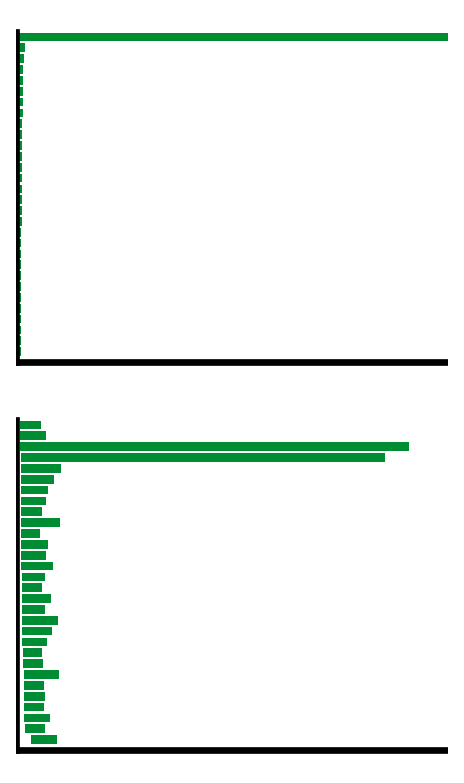

C:\Users\Finnern\AppData\Local\Temp/ipykernel_21168/391287716.py:75: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  v1[i, :] = [i, np.where(verts == edges[0][i])[0]]
C:\Users\Finnern\AppData\Local\Temp/ipykernel_21168/391287716.py:76: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  v2[i, :] = [i, np.where(verts == edges[1][i])[0]]


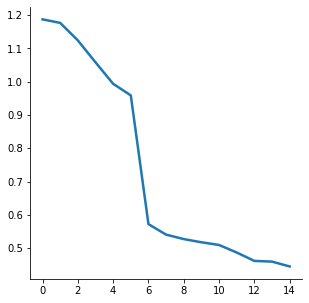

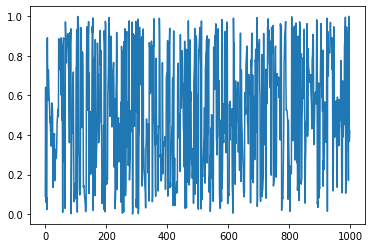

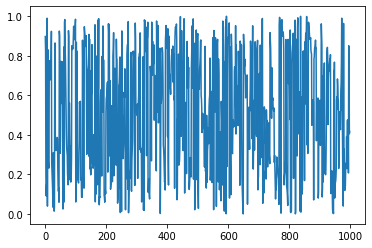

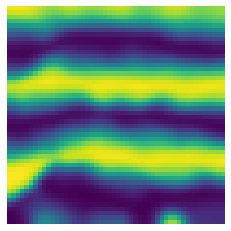

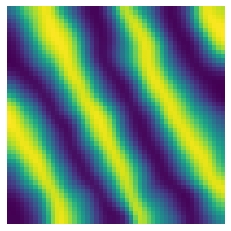

In [3]:
xy_all = {}
movetimes_all = {}
spk_all = {}
coords_all = {}
data_dir = 'weijan'
mouse = '97046'
sess_all = ['20210308','20210312']
for sess in sess_all:
    print(sess)    
    NAT = h5py.File(data_dir + '/' + mouse + '/' + sess + '/' + 'NAT.mat')
    nat_all = NAT[NAT['NAT'][()][0][0]][()]
    
    filtered_events = nat_all[np.arange(15,len(nat_all), 4),:]
    tt = nat_all[0,:]
    headpos = nat_all[1:3,:].T
    headdirection = nat_all[3,:]    
    speed = nat_all[4,:]

    sspikes = np.zeros(np.shape(filtered_events)).T
    for i in range(len(filtered_events)):
        if np.sum(np.isnan(filtered_events[i,:]))== len(tt):
            continue
        if np.isnan(filtered_events[i,0]):
            sspikes[1:-1,i] = interp1d(tt[np.arange(1,len(tt),2)], filtered_events[i,np.arange(1,len(tt),2)])(tt[1:-1])
        else:
            sspikes[1:-1,i] = interp1d(tt[np.arange(0,len(tt),2)], filtered_events[i,np.arange(0,len(tt),2)])(tt[1:-1])    
    
        
    sspikes = sspikes[1:-1,:]
    tt = tt[1:-1]
    headpos = headpos[1:-1,:]
    speed = speed[1:-1]
    
    NeuronInformation = h5py.File(data_dir + '/' + mouse + '/' + sess + '/' + 'NeuronInformation.mat')['NeuronInformation']
    repremove = np.ones(len(sspikes[0,:]), dtype = bool)
    repremove[NeuronInformation['RepeatCell'][()][0].astype(int)-1] = False
    sspikes = sspikes[:, repremove]
    sspikes[np.isnan(sspikes)] = 0
    sspikes[sspikes<0.001] = 0
    spksum = np.mean(sspikes,0)
    plt.plot(np.sort(spksum))
    indssort = np.where((spksum>0) & (spksum<10))   [0]
    
    movetimes0 = np.where(speed>5)[0]
    sspk1 = sspikes[:,indssort][movetimes0,:]#,sigma = 1, axis = 0)[:,indssort][movetimes0,:]
    spknull0 = sspk1.sum(0)>0
    sspk1 = sspk1[:, spknull0 ]
    spknull = np.sum(sspk1,1)>0
    sspk1 = sspk1[spknull,:]
    movetimes0 = movetimes0[spknull]

    xy_all[sess] = headpos.copy()
    movetimes_all[sess] = movetimes0.copy()
    spk_all[sess] = sspk1.copy()

    indstemp = []
    dgms, rips_real, indstemp, movetimes1, var_exp = get_dgms(sspk1,
                                                              maxdim = 1, k = 1000, n_points = 1000, 
                                                              dim =6, nbs = 1000, eps = 0.5, indstemp = indstemp)
    fig = plot_barcode(dgms[0])
    plt.show()
    np.savez('weijan/' + mouse + '_' + sess + '_d', d = rips_real['dperm2all'])

    
    fig,ax = plt.subplots(1,1, figsize = (5,5))
    
    ax.plot(var_exp[:15], lw = 2.5)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.set_aspect(1/ax.get_data_ratio())


    coords_ds =  get_coords_ds(rips_real, len(indstemp), ph_classes = [0,1,], 
                              dec_thresh = 0.99, coeff = 47)
    plt.figure()
    plt.plot(coords_ds[0,np.argsort(indstemp)])
    plt.figure()
    plt.plot(coords_ds[1,np.argsort(indstemp)])

    coords_mod1 = get_coords_all(sspk1[:,:], coords_ds, 
                                 np.arange(len(sspk1[:,0])),                             
                                 indstemp, dim = 6, bPred = False, bPCA = True)
    coords_all[sess] = coords_mod1.copy()
 
    np.savez(data_dir + '/' + mouse + '/' + sess + '/decoding_data', indstemp = indstemp, coords_ds = coords_ds)
    
    sig = 2
    plt.viridis()
    for c in [0,1,]:
        fig, axs = plt.subplots(1,1)
        nans0 = ~np.isnan(coords_mod1[:,c])
        mtot, __, __, circ = binned_statistic_2d(headpos[movetimes0,0][nans0], 
                                                 headpos[movetimes0,1][nans0],
                                                 coords_mod1[:,c][nans0], 
                                                 statistic = circmean, bins = 50,
                                                 expand_binnumbers = True)

        nans = np.isnan(mtot)
        sintot = np.sin(mtot)
        costot = np.cos(mtot)
        sintot[nans] = np.mean(sintot[~nans])
        costot[nans] = np.mean(costot[~nans])
        sintot = gaussian_filter(sintot,sig)
        costot = gaussian_filter(costot,sig)
        mtot = np.cos(np.arctan2(sintot, costot))
        mtot = gaussian_filter(mtot, 1)
        plt.viridis()
    #    mtot[nans] = np.nan
        axs.imshow(mtot)
        axs.axis('off')
        axs.set_aspect(1/axs.get_data_ratio())
        fig.savefig('Figs/' + mouse + '_' + sess + '_stripes' + str(c) + '.png', transparent = True)
        fig.savefig('Figs/' + mouse + '_' + sess + '_stripes' + str(c) + '.pdf', transparent = True)

    plt.show()


100
[1.11848724 1.11848724 1.11848724 1.11848724 1.11848724 1.11848724
 1.11848724 1.11848724 1.11848724 1.11848724 1.11848724 1.11848724
 1.11848724 1.11848724 1.11848724 1.11848724 1.11848724 1.11848724
 1.11848724 1.11848724 1.11848724 1.11848724 1.11848724 1.11848724
 1.11848724 1.11848724 1.11848724 1.11848724 1.11848724 1.11848724]
infinity 16.040533351898194
[3.2694135  2.40217248 2.29149076 2.29143578 2.18895566 2.18369475
 2.16507226 2.15713769 2.15275478 2.14448413 2.13596079 2.11210325
 2.11169109 2.09844184 2.09402645 2.092783   2.0877572  2.08668451
 2.08525552 2.07758364 2.07507409 2.063116   2.05919567 2.05059837
 2.04972775 2.04536495 2.040811   2.01505716 2.00750072 2.00232752]
infinity 16.040533351898194
[16.40115809 15.90655684 15.18756461 14.99861503 14.56010604 13.72337699
 13.65155959 13.31763339 13.22640014 12.93166041 12.23210406  4.68368673
  4.40198684  3.73197258  3.69956124  3.54565096  3.10391665  2.87409776
  2.8575567   2.80232179  2.76538235  2.67768925 

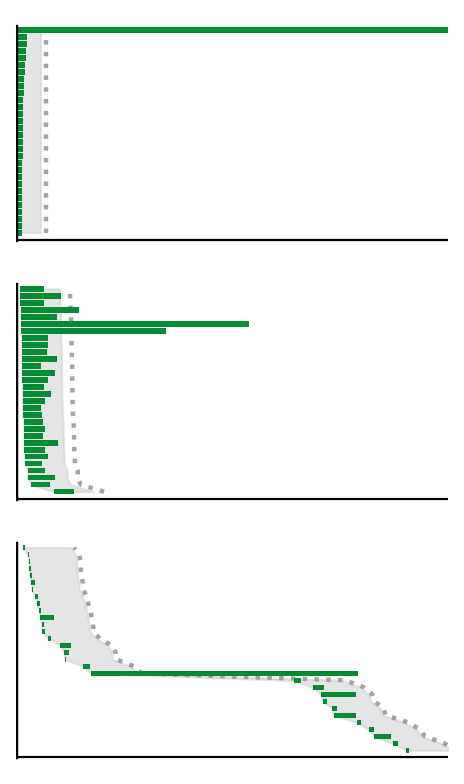

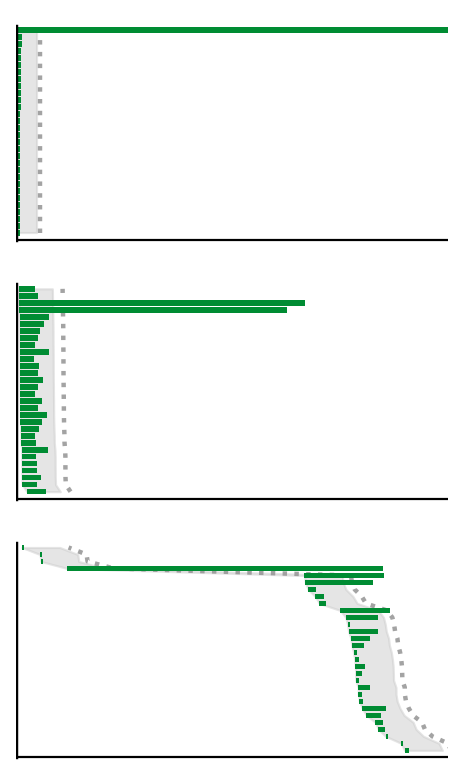

In [3]:
mouse = '97046'
for sess in ['20210308', '20210312',]:
    shuf_all = {}
    shuffle_name1 = 'weijan/' + mouse + '_' + sess + '_shuffles_concatenated.npz'
    shuffle_name2 = 'weijan/' + mouse + '_' + sess + '_shuffles_concatenated_2.npz'
    shuffle_name3 = 'weijan/' + mouse + '_' + sess + '_shuffles_concatenated3'
    shuf = np.load(shuffle_name1, allow_pickle = True)
    shuf1 = shuf['dgms_shuffles'][()]
    shuf.close()
    for s in shuf1:
        shuf_all[s] = shuf1[s]
        
    shuf = np.load(shuffle_name2, allow_pickle = True)
    shuf2 = shuf['dgms_shuffles'][()]
    shuf.close()
    for s in shuf2:
        shuf_all[s] = shuf2[s]
    np.savez(shuffle_name3, dgms_shuffles = shuf_all)
        
    
    f = np.load('weijan/' + mouse + '_' + sess + '_H2.npz', allow_pickle = True)
    dgms = list(f['dgms'])
    f.close()
    fig = plot_barcode(dgms, shuffle_name = shuffle_name3)
    fig.savefig('Figs/' + mouse + '_' + sess + '_barcode.png', transparent = True)
    fig.savefig('Figs/' + mouse + '_' + sess + '_barcode.pdf', transparent = True)


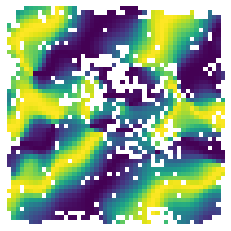

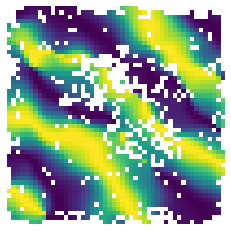

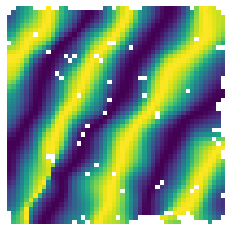

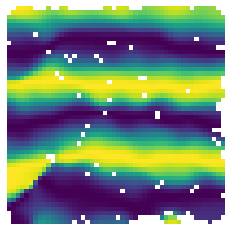

In [4]:
coords_aligned = {}
for sess in sess_all:
    coords_mod1 = coords_all[sess].copy()
    headpos = xy_all[sess].copy()
    movetimes0 = movetimes_all[sess].copy()
    if sess == '20210308':
        ctmp = 2*np.pi - coords_mod1[:,0].copy()
        coords_mod1[:,0] -= 2/np.sqrt(3)*coords_mod1[:,1]
#        coords_mod1[:,1] += 2/np.sqrt(3)*ctmp
    if sess == '20210312':
        coords_mod1[:,1] = 2*np.pi-coords_mod1[:,1] + 2/np.sqrt(3)*coords_mod1[:,0]
        ctmp = coords_mod1[:,0].copy()
        coords_mod1[:,0] = coords_mod1[:,1].copy()
        coords_mod1[:,1] = ctmp.copy()
    coords_mod1 = coords_mod1%(2*np.pi)
    coords_aligned[sess] = coords_mod1.copy()
    for c in [0,1,]:
        fig, axs = plt.subplots(1,1)
        nans0 = ~np.isnan(coords_mod1[:,c])
        mtot, __, __, circ  = binned_statistic_2d(headpos[movetimes0,0][nans0],
                                                  headpos[movetimes0,1][nans0],
                                                  coords_mod1[:,c][nans0], 
                                                  statistic = circmean, 
                                                  bins = 50,
                                                  expand_binnumbers = True)

        nans = np.isnan(mtot)
        sintot = np.sin(mtot)
        costot = np.cos(mtot)
        sintot[nans] = np.mean(sintot[~nans])
        costot[nans] = np.mean(costot[~nans])
        sintot = gaussian_filter(sintot,sig)
        costot = gaussian_filter(costot,sig)
        mtot = np.cos(np.arctan2(sintot, costot))
#            mtot = gaussian_filter(mtot, 1)
        plt.viridis()
        mtot[nans] = np.nan
        axs.imshow(mtot)
        axs.axis('off')
        axs.set_aspect(1/axs.get_data_ratio())
        fig.savefig('Figs/' + mouse + '_' + sess + '_stripes' + str(c) + '.png', transparent = True)
        fig.savefig('Figs/' + mouse + '_' + sess + '_stripes' + str(c) + '.pdf', transparent = True)


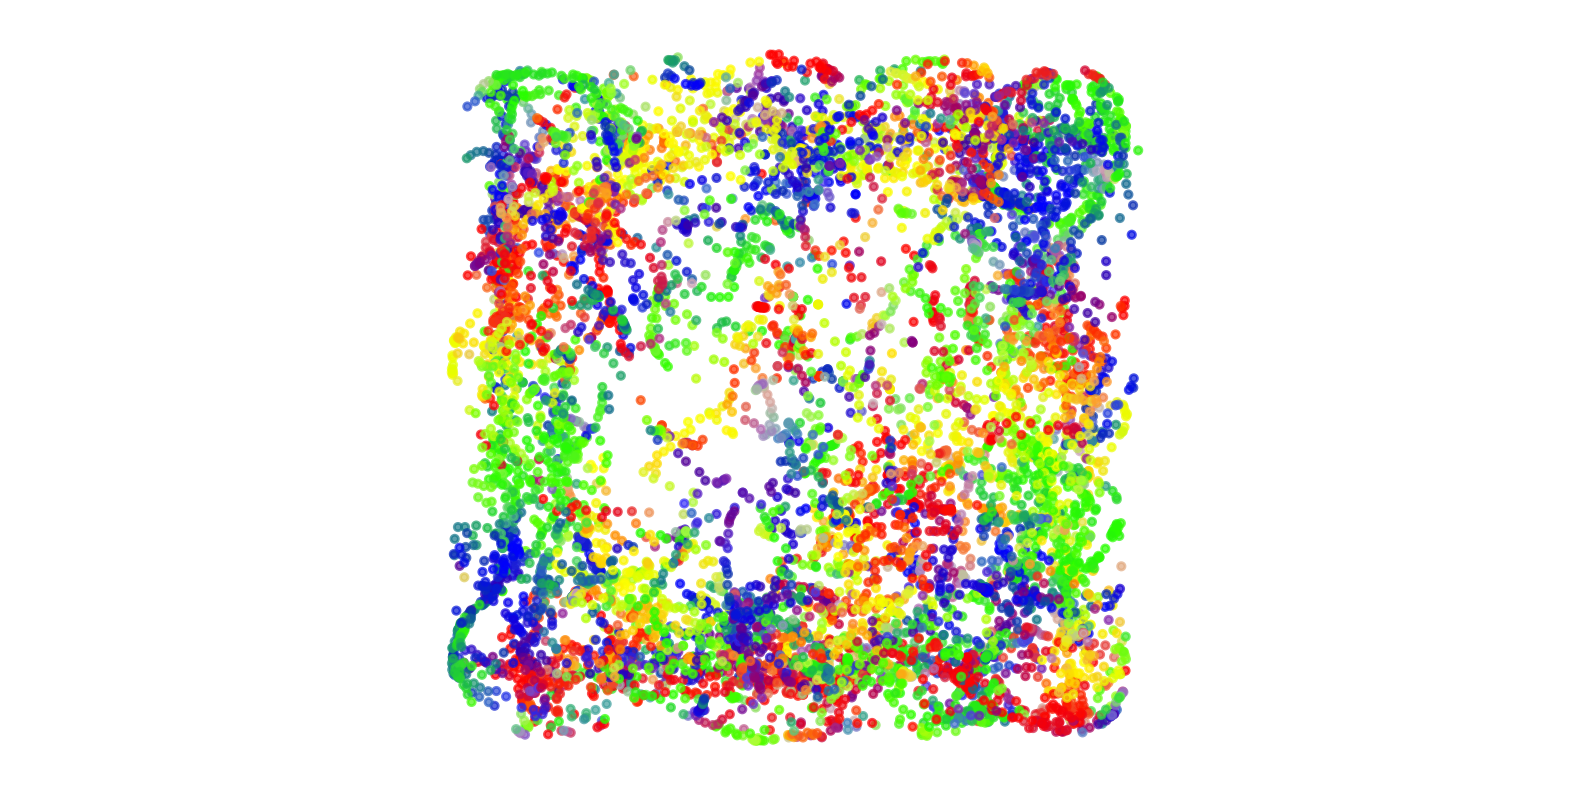

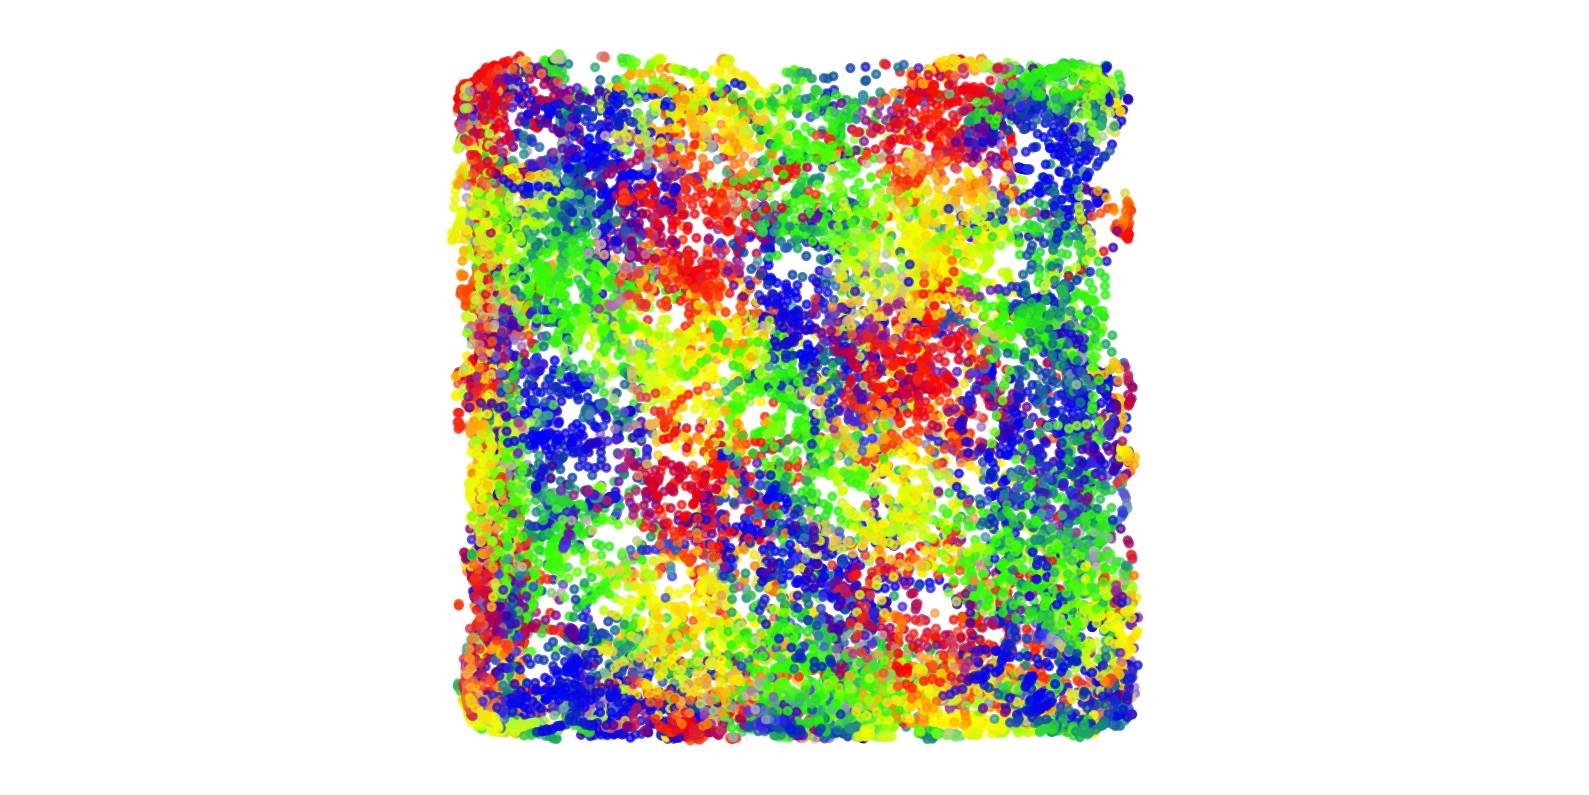

In [42]:
for sess in sess_all:
    coords_mod1 = coords_all[sess].copy()
    headpos = xy_all[sess].copy()
    movetimes0 = movetimes_all[sess].copy()
    coords_mod1 = coords_aligned[sess].copy()

    im = plt.imread('C:\\Users\\Finnern\\OneDrive - NTNU\\Giocomo\\image044.png')
    im = np.array(im)
    a1 = np.rot90(im, 1)
    sp = -np.inf
    sig = 1

    cc = np.arctan2(gaussian_filter1d(np.sin(coords_mod1),sigma = sig,axis = 0),
                   gaussian_filter1d(np.cos(coords_mod1),sigma = sig,axis = 0))%(2*np.pi)
    bCos = True
    if bCos:
        eps = 0.0001 
        digitized = np.concatenate((np.digitize(np.cos(cc[:, 0]), np.linspace(-1-eps,1+eps, len(a1)+1))[:,np.newaxis], 
                            np.digitize(np.cos(cc[:, 1]), np.linspace(-1-eps,1+eps, len(a1)+1))[:,np.newaxis]),1)
    else:
        digitized = np.concatenate((np.digitize(cc[:, 0], np.linspace(0,2*np.pi, len(a1)+1))[:,np.newaxis], 
                                   np.digitize(cc[:, 1], np.linspace(0,2*np.pi, len(a1)+1))[:,np.newaxis]),1)
    cc1 = []
    for i in range(len(digitized)):
        cc1.append(a1[digitized[i,1]-1, digitized[i,0]-1]) 
    fig = plt.figure(figsize = (10,5), dpi = 200)
    plt.axis('off')
    plt.hsv()
    ax1 = fig.add_subplot(111)
    ax1.axis('off')
    im = ax1.scatter(headpos[movetimes0,0], headpos[movetimes0,1], s = 7, c = cc1, alpha  =0.7)
    ax1.set_aspect(1/ax1.get_data_ratio())
    plt.show()

    fig.savefig('Figs/' + mouse + '_' + sess + '_stripes' + str(c) + '_2dcoords.png', transparent = True)
    fig.savefig('Figs/' + mouse + '_' + sess + '_stripes' + str(c) + '_2dcoords.pdf', transparent = True)




In [1]:
## Plot toroidal ratemaps
numbins1 = 30
sig1 = 2
roll = 3

plt.viridis()
for sessit, sess in enumerate(sess_all[:1]):
    try:
        os.mkdir('Figs/' + mouse + '_' + sess )
    except:
        print('folder made')
        
    NAT = h5py.File(data_dir + '/' + mouse + '/' + sess + '/' + 'NAT.mat')
    nat_all = NAT[NAT['NAT'][()][0][0]][()]
    filtered_events = nat_all[np.arange(15,len(nat_all), 4),:]
    tt = nat_all[0,:]
    headpos = nat_all[1:3,:].T
    headdirection = nat_all[3,:]    
    speed = nat_all[4,:]

    sspikes = np.zeros(np.shape(filtered_events)).T
    for i in range(len(filtered_events)):
        if np.sum(np.isnan(filtered_events[i,:]))== len(tt):
            continue
        if np.isnan(filtered_events[i,0]):
            sspikes[1:-1,i] = interp1d(tt[np.arange(1,len(tt),2)], filtered_events[i,np.arange(1,len(tt),2)])(tt[1:-1])
        else:
            sspikes[1:-1,i] = interp1d(tt[np.arange(0,len(tt),2)], filtered_events[i,np.arange(0,len(tt),2)])(tt[1:-1])    
    
        
    sspikes = sspikes[1:-1,:]
    tt = tt[1:-1]
    headpos = headpos[1:-1,:]
    speed = speed[1:-1]
    
    NeuronInformation = h5py.File(data_dir + '/' + mouse + '/' + sess + '/' + 'NeuronInformation.mat')['NeuronInformation']
    repremove = np.ones(len(sspikes[0,:]), dtype = bool)
    repremove[NeuronInformation['RepeatCell'][()][0].astype(int)-1] = False
    sspikes = sspikes[:, repremove]
    sspikes[np.isnan(sspikes)] = 0
    sspikes[sspikes<0.001] = 0
    spksum = np.mean(sspikes,0)
    plt.plot(np.sort(spksum))
    indssort = np.where((spksum>0) & (spksum<10))   [0]
    
    movetimes0 = np.where(speed>5)[0]
    sspk1 = sspikes[:,indssort][movetimes0,:]#,sigma = 1, axis = 0)[:,indssort][movetimes0,:]
    spknull0 = sspk1.sum(0)>0
    sspk1 = sspk1[:, spknull0 ]
    spknull = np.sum(sspk1,1)>0
    sspk1 = sspk1[spknull,:]
    movetimes0 = movetimes0[spknull]
    
    xy_all[sess] = headpos.copy()
    movetimes_all[sess] = movetimes0.copy()
            
    num_neurons = len(sspk1[0,:])
    pp = coords_aligned[sess].copy()%(2*np.pi)

    for it,  n in enumerate(range(num_neurons)):#enumerate(IsGridCell[:5].astype(int)):    
        fig, axs = plt.subplots(1,2)
        mtot_tmp, x_edge, y_edge,c2 = binned_statistic_2d(headpos[movetimes0,0], headpos[movetimes0,1],
                                      sspk1[:,n], statistic='mean', 
                                     bins=numbins1, range=None, expand_binnumbers=True)


        nans = np.isnan(mtot_tmp)
        mtot_tmp[np.isnan(mtot_tmp)] = np.mean(mtot_tmp[~np.isnan(mtot_tmp)])
        nans = np.isnan(mtot_tmp)
        mtot_tmp[nans] = np.mean(mtot_tmp[~nans])
        mtot_tmp = gaussian_filter(mtot_tmp,sigma = sig1)
        mtot_tmp[nans] = np.nan
        
        ax = axs[0]
        ax.imshow(mtot_tmp, origin = 'lower', extent = [0,2*np.pi,0, 2*np.pi], vmin = 0, vmax = np.max(mtot_tmp) *0.975)
        ax.set_xticks([])
        ax.set_yticks([])

        mtot_tmp, x_edge, y_edge,c2 = binned_statistic_2d(pp[:,0], pp[:,1],
                                              sspk1[:,n], statistic='mean', 
                                             bins=numbins1, range=None, expand_binnumbers=True)
        nans = np.isnan(mtot_tmp)
        mtot_tmp[np.isnan(mtot_tmp)] = np.mean(mtot_tmp[~np.isnan(mtot_tmp)])
        if sess == '20210308':
            mtot_tmp = smooth_tuning_map(np.rot90(mtot_tmp,0), numbins1+1, sig1, bClose = True) 
        elif sess == '20210312':
            mtot_tmp = smooth_tuning_map(np.rot90(mtot_tmp,1), numbins1+1, sig1, bClose = True) 
        mtot_tmp[nans] = -np.inf
        ax = axs[1]
        ax.imshow(mtot_tmp, origin = 'lower', extent = [0,2*np.pi,0, 2*np.pi], vmin = 0, vmax = np.max(mtot_tmp) *0.975)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_aspect(1/ax.get_data_ratio())
        r_box = transforms.Affine2D().skew_deg(15,15)

        for x in ax.images + ax.lines + ax.collections:
            trans = x.get_transform()
            x.set_transform(r_box+trans) 
            if isinstance(x, PathCollection):
                transoff = x.get_offset_transform()
                x._transOffset = r_box+transoff     
        ax.set_xlim(0, 2*np.pi + 3*np.pi/5)
        ax.set_ylim(0, 2*np.pi + 3*np.pi/5)
        ax.set_aspect('equal', 'box') 
        ax.axis('off')   
        fig.savefig('Figs/' + mouse +'_' + sess+ '/toroidal_ratemap' + str(it) + '.png', transparent = True, pad_inches = 0.1)
        fig.savefig('Figs/' + mouse +'_' + sess+ '/toroidal_ratemap' + str(it) + '.pdf', transparent = True, pad_inches = 0.1)
        plt.close()


NameError: name 'plt' is not defined